In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import entropy
import os
import sys
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
le = LabelEncoder()
import pyod
# Load training data from A2_1
task1_data_dir = '/Users/adityadesu/Desktop/COMP90073/Assignment - 2/A2_1'
rootpath2 = '/Users/adityadesu/Desktop/COMP90073/Assignement - 2 Report/'

In [8]:
#Load training data
train_data = pd.read_csv(os.path.join(task1_data_dir, '1_training_data.csv'))

# Load validation data
val_data = pd.read_csv(os.path.join(task1_data_dir, '1_validation_data_with_label.csv'))

# Load test data
test_data = pd.read_csv(os.path.join(task1_data_dir, '1_test_data.csv'))

# Add a column names to all the dataframes
features = ['stream_ID','date-time', 'duration','protocol', 'src_ip', 'src_port', 'direction', 'dst_ip', 'dst_port', 'state', 'src_type', 'dst_type','total_packets', 'two-way-byte_transf', 'src-dst-byte-transf', 'label']
train_data.columns = features
val_data.columns = features
test_data.columns = features


# count of instances with null values
print("Count of instances with missing values:\n",train_data.isnull().sum())

# Fill missing values with mode
train_data['src_type'].fillna(train_data['src_type'].mode()[0], inplace=True)
train_data['dst_type'].fillna(train_data['dst_type'].mode()[0], inplace=True)

val_data['src_type'].fillna(val_data['src_type'].mode()[0], inplace=True)
val_data['dst_type'].fillna(val_data['dst_type'].mode()[0], inplace=True)

test_data['src_type'].fillna(test_data['src_type'].mode()[0], inplace=True)
test_data['dst_type'].fillna(test_data['dst_type'].mode()[0], inplace=True)

# Drop null values
train_data = train_data.dropna()

# Convert anomaly to 1 and normal to 0
train_data.loc[train_data['label'].str.contains('Botnet'), 'label'] = 1
train_data.loc[train_data['label'].str.contains('Botnet')==False, 'label'] = 0

val_data.loc[val_data['label'].str.contains('Botnet'), 'label'] = 1
val_data.loc[val_data['label'].str.contains('Botnet')==False, 'label'] = 0

test_data.loc[test_data['label'].str.contains('Botnet'), 'label'] = 1
test_data.loc[test_data['label'].str.contains('Botnet')==False, 'label'] = 0

# Save labels of data
train_labels = train_data['label'].values
val_labels = val_data['label'].values
test_labels = test_data['label'].values

# Save stream_ID of data
train_stream_ID = train_data['stream_ID'].values
val_stream_ID = val_data['stream_ID'].values
test_stream_ID = test_data['stream_ID'].values

# Drop labels
train_data = train_data.drop('label', axis=1)
val_data = val_data.drop('label', axis=1)

# Drop stream_ID
# train_data = train_data.drop('stream_ID', axis=1)
# val_data = val_data.drop('stream_ID', axis=1)
# test_data = test_data.drop('stream_ID', axis=1)
test_data.head()


Count of instances with missing values:
 stream_ID                   0
date-time                   0
duration                    0
protocol                    0
src_ip                      0
src_port                    0
direction                   0
dst_ip                      0
dst_port                    0
state                      12
src_type                 6041
dst_type               255279
total_packets               0
two-way-byte_transf         0
src-dst-byte-transf         0
label                       0
dtype: int64


,stream_ID,date-time,duration,protocol,src_ip,src_port,direction,dst_ip,dst_port,state,src_type,dst_type,total_packets,two-way-byte_transf,src-dst-byte-transf,label
0,2,2021-08-12 20:56:02.051273,0.000458,udp,216.149.170.165,15135,<->,150.35.87.232,13365,CON,0.0,0.0,2,130,71,0
1,3,2021-08-12 20:56:02.056605,0.140449,tcp,81.114.119.142,3577,->,150.35.87.133,80,FSPA_FSPA,0.0,0.0,16,9359,1084,0
2,4,2021-08-12 20:56:02.108284,0.000666,udp,150.35.87.141,55454,<->,150.35.83.12,53,CON,0.0,0.0,1,215,81,0
3,5,2021-08-12 20:56:02.108367,0.000749,udp,150.35.87.141,51411,<->,150.35.83.12,53,CON,0.0,0.0,1,213,81,0
4,6,2021-08-12 20:56:02.110327,0.585274,tcp,150.35.89.129,43859,->,92.188.3.136,443,SRPA_FSPA,0.0,0.0,19,4548,1133,0


**Feature Standardisation**

In [ ]:
# Standardise features
def feature_standardiser(df,le):
    '''Standardise features and encode categorical features
        params:
            df: dataframe
            le: LabelEncoder object
        returns:
            df: dataframe with standardised features'''

    try:
        # Encode categorical features
        df['protocol'] = le.fit_transform(df['protocol'])
        df['state'] = le.fit_transform(df['state'])
        df['src_ip'] = le.fit_transform(df['src_ip'])
        df['dst_ip'] = le.fit_transform(df['dst_ip'])
        df['direction'] = le.fit_transform(df['direction'])
        df['flow'] = le.fit_transform(df['flow'])
        
    except:
        print("Already encoded")

    try:
        df['date-time'] = pd.to_datetime(df['date-time'])
        df['date-time'] = pd.to_numeric(df['date-time'])
    except:
        print("Already dropped")
   #don't scale duration maybe

    #Scale features StandardScaler 
    scaler = StandardScaler()
    df['date-time'] = pd.to_numeric(df['date-time'])
    scaler_columns = df.columns[1:]
  
    scaled_features = scaler.fit_transform(df[scaler_columns])
    scaled_df = pd.DataFrame()
    scaled_df['date-time'] = df['date-time']
    scaled_df[scaler_columns] = scaled_features
    
    return df


# try:
#     train_data.drop('date-time', axis=1, inplace=True)
# except:
#     print("Already dropped date-time")

train_data = feature_standardiser(train_data,le)
display(train_data.head())

# Keep track of initial training features to see which get dropped through feature selection
initial_features = train_data.columns

In [4]:

unscaled_train_data = pd.read_csv(os.path.join(rootpath2, 'stanadarised_unscaled_train_data.csv'))
unscaled_val_data = pd.read_csv(os.path.join(rootpath2, 'stanadarised_unscaled_val_data.csv'))
unscaled_test_data = pd.read_csv(os.path.join(rootpath2, 'stanadarised_unscaled_test_data.csv'))

initial_features = unscaled_train_data.columns
unscaled_train_data.head()

,date-time,duration,protocol,src_ip,src_port,direction,dst_ip,dst_port,state,src_type,dst_type,total_packets,two-way-byte_transf,src-dst-byte-transf
0,1628450689907604000,602.160441,10,98082,51200,3,22466,13360,6,0.0,0.0,3,264,145
1,1628450689949670000,0.188379,9,63612,1573,0,44908,80,63,0.0,0.0,12,6036,749
2,1628450689966218000,1897.815694,10,216037,34035,3,22466,13361,6,0.0,0.0,11,1356,522
3,1628450689976393000,0.000000,9,46933,10299,1,22401,6880,134,0.0,0.0,0,59,59
4,1628450689983695000,0.001152,10,31560,7289,3,22466,13362,6,0.0,0.0,1,552,76


**Feature Generation**

In [ ]:

def feature_generator(df):
    ''' Generate features from the data
    params:
        df: dataframe
    returns:
        df: dataframe with new features'''
    # Join src ip, dst ip and dst port
    #df['irc'] = df['src_ip'].str.cat(df['dst_ip'], sep="").str.cat(df['dst_port'].astype(str), sep="")
    feature_generated_df = pd.DataFrame()
    #Compute difference between alternate date-time values
    feature_generated_df['pps'] = df['total_packets']/df['duration'].replace({0:np.inf})
    feature_generated_df['bps'] = df['two-way-byte_transf']/df['duration'].replace({0:np.inf})
    feature_generated_df['bps_src'] = df['src-dst-byte-transf']/df['duration'].replace({0:np.inf})
    feature_generated_df['bps_two-way'] = df['two-way-byte_transf']/df['duration'].replace({0:np.inf})
    feature_generated_df['date-time'] = pd.to_datetime(df['date-time'])
    duration = feature_generated_df['date-time'].diff().dt.total_seconds()
    duration = duration.fillna(0)
    feature_generated_df['time_diff'] = pd.to_numeric(duration)
    feature_generated_df.drop('date-time', axis=1, inplace=True)
    
    return feature_generated_df

# Generate features
feature_generated_training_data = feature_generator(unscaled_train_data)
feature_generated_val_data = feature_generator(unscaled_val_data)
feature_generated_test_data = feature_generator(unscaled_test_data)

feature_generated_training_data.head()


In [5]:
# Write to csv
feature_generated_training_data = pd.read_csv(os.path.join(rootpath2, 'feature_generated_training_data.csv'))
feature_generated_val_data = pd.read_csv(os.path.join(rootpath2, 'feature_generated_val_data.csv'))
feature_generated_test_data = pd.read_csv(os.path.join(rootpath2, 'feature_generated_test_data.csv'))

**Feature Selection Filter Based Method 1- Variance Threshold**

In [ ]:
# Remove features with low variance using variance threshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(unscaled_train_data)
variance_threshold_train_data = unscaled_train_data[unscaled_train_data.columns[sel.get_support(indices=True)]]

# Find the features removed after variance threshold
removed_features = [x for x in initial_features if x not in variance_threshold_train_data.columns]
print("Features removed after variance threshold: ", removed_features)
variance_threshold_train_data.head()

**Use same features as training for validation and testing**

In [ ]:
print("Saving data to csv")
#Write to csv
variance_threshold_train_data.to_csv(os.path.join(rootpath2, 'variance_threshold_train_data.csv'), index=False)
# Assign same features as training data to validation and test data
variance_threshold_val_data = unscaled_val_data[variance_threshold_train_data.columns]
variance_threshold_test_data = unscaled_test_data[variance_threshold_train_data.columns]

variance_threshold_val_data.to_csv(os.path.join(rootpath2, 'variance_threshold_val_data.csv'), index=False)
variance_threshold_test_data.to_csv(os.path.join(rootpath2, 'variance_threshold_test_data.csv'), index=False)

In [9]:
variance_threshold_train_data = pd.read_csv(os.path.join(rootpath2, 'variance_threshold_train_data.csv'))
variance_threshold_val_data = pd.read_csv(os.path.join(rootpath2, 'variance_threshold_val_data.csv'))
variance_threshold_test_data = pd.read_csv(os.path.join(rootpath2, 'variance_threshold_test_data.csv'))
variance_threshold_train_data.head()

,date-time,duration,protocol,src_ip,src_port,direction,dst_ip,dst_port,state,src_type,total_packets,two-way-byte_transf,src-dst-byte-transf
0,1628450689907604000,602.160441,10,98082,51200,3,22466,13360,6,0.0,3,264,145
1,1628450689949670000,0.188379,9,63612,1573,0,44908,80,63,0.0,12,6036,749
2,1628450689966218000,1897.815694,10,216037,34035,3,22466,13361,6,0.0,11,1356,522
3,1628450689976393000,0.000000,9,46933,10299,1,22401,6880,134,0.0,0,59,59
4,1628450689983695000,0.001152,10,31560,7289,3,22466,13362,6,0.0,1,552,76


**Feature Selection Method 2- Correlation and VIF Factor**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# identify features with high correlation using pearson correlation and select them using variance inflation factor
# calculate the correlation matrix
corr = unscaled_train_data.corr(method='pearson')
# plot the heatmap
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

# Calculate VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(unscaled_train_data.values, i) for i in range(unscaled_train_data.shape[1])]
vif["features"] = unscaled_train_data.columns

display(vif)

In [ ]:

# Drop features with VIF > 10
vif = vif[vif['VIF Factor'] < 10]
vif_train_data = unscaled_train_data.copy()
vif_train_data = vif_train_data[vif['features']]
vif_features = vif_train_data.columns
# print the features removed after VIF
removed_features = [x for x in initial_features if x not in vif_features]
print("Features removed after VIF: ", removed_features)
vif_train_data.head()

**Date Time feature removed for validation and testing by Peasron Correlation and Variance Inflation Factor Method**

In [ ]:
# Remove features for which VIF > 10 for validation and test data
vif_val_data = unscaled_val_data.copy()
vif_val_data = vif_val_data[vif['features']]
vif_test_data = unscaled_test_data.copy()
vif_test_data = vif_test_data[vif['features']]
# Write to csv
vif_train_data.to_csv(os.path.join(rootpath2, 'vif_train_data.csv'), index=False)
vif_val_data.to_csv(os.path.join(rootpath2, 'vif_val_data.csv'), index=False)
vif_test_data.to_csv(os.path.join(rootpath2, 'vif_test_data.csv'), index=False)

In [6]:
# Read from csv
vif_train_data = pd.read_csv(os.path.join(rootpath2, 'vif_train_data.csv'))
vif_val_data = pd.read_csv(os.path.join(rootpath2, 'vif_val_data.csv'))
vif_test_data = pd.read_csv(os.path.join(rootpath2, 'vif_test_data.csv'))

In [10]:
def accurate_outlier_preds(preds,labels):
    ''' Calaculate the number of accurate outlier predictions
        params:
            preds: predictions
            train_labels: true labels
        returns:
            number of accurate outlier predictions'''
    accurate_outlier_count = 0
    for i in range(len(preds)):
        if preds[i] == 1:
            if labels[i] == 1:
                accurate_outlier_count +=1
    return accurate_outlier_count

def predict_and_show_results(clf,data,true_labels, model_data,train_flag):
    '''Takes in a classifier and data and predicts the labels and shows the results
    params:
        clf: classifier
        variance_threshold_train_data: data
    returns:
        None'''

    target_names = ['Normal', 'Anomaly']

    if train_flag:
        y_pred = clf.fit_predict(data)
    else:
        # Predict the labels
        y_pred = clf.predict(data)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1


    n_errors = (y_pred != true_labels).sum()
    print(model_data)
    print("Number of errors: ", n_errors)
#Store index of anamoalies in trainin data
    anomaly_count = np.sum(true_labels)
# Store index of predicted anomalies in training data
    predicted_anomaly_index = np.where(y_pred == 1)

    accurate_outlier_count = accurate_outlier_preds(y_pred,true_labels)
    print("Accuracy for outliers: ", accurate_outlier_count/anomaly_count)

# Find accuracy of identified anomalies
    print("Classification report: \n", classification_report(list(true_labels), list(y_pred), target_names=['Normal', 'Anomaly']))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(list(true_labels), list(y_pred))

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(10,10))
    sns.heatmap(cnf_matrix, xticklabels=target_names, yticklabels=target_names, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()


    return y_pred


**Training**

**Model 1-Isolation Forest**

In [10]:
# Remove features identified by information gain
#train_data = train_data[selected_features]

# implement isolation forest

from sklearn.metrics import accuracy_score


clf = IsolationForest(contamination=0.15)
clf.fit(variance_threshold_train_data)


#predict_and_show_results(clf,feature_generated_training_data)




X does not have valid feature names, but IsolationForest was fitted with feature names


IsolationForest(contamination=0.15)

**Standardise Validation dataset**

In [ ]:
variance_threshold_train_data.head()

In [ ]:
y_pred_val = predict_and_show_results(clf,variance_threshold_val_data,val_labels, "Isolation Forest for variance threshold validation data", False)

**Test Data Results**

Isolation Forest for variance threshold test data
Number of errors:  194042
Accuracy for outliers:  0.8912896691424713
Classification report: 
               precision    recall  f1-score   support

      Normal       1.00      0.75      0.85    761760
     Anomaly       0.01      0.89      0.03      2962

    accuracy                           0.75    764722
   macro avg       0.51      0.82      0.44    764722
weighted avg       1.00      0.75      0.85    764722



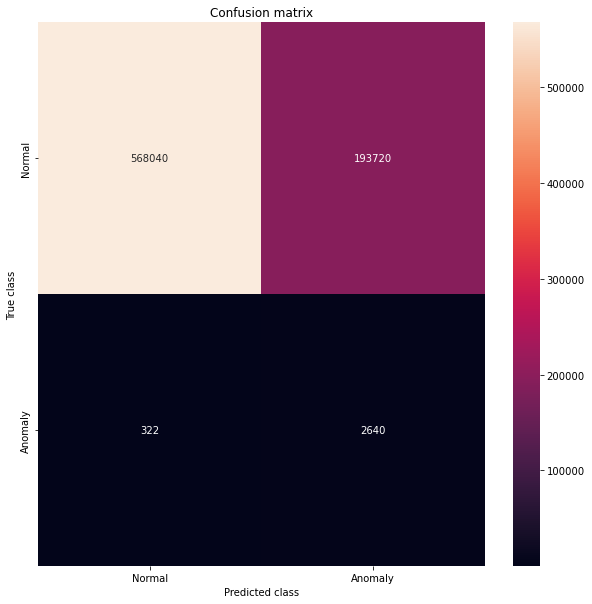

In [25]:
y_pred_test = predict_and_show_results(clf,variance_threshold_test_data,test_labels, "Isolation Forest for variance threshold test data",False)

In [26]:
#Find stream id of all predicted anomalies
anomaly_stream_ids = []
for i in range(len(y_pred_test)):
    if y_pred_test[i] == 1:
        anomaly_stream_ids.append(test_stream_ID[i])

# Write the stream ids of anomalies to a file
with open('predicted_anomaly_stream_ids_variance_threshold.txt', 'w') as f:
    for item in anomaly_stream_ids:
        f.write("%s\n" % item)




In [43]:
# Write the stream ids, timestamp, src_ip and dst_ip of anomalies to a file
with open('predicted_anomaly_stream_ids_variance_threshold-results.csv', 'w') as f:
    f.write("stream_id,timestamp,src_ip,dst_ip,label\n")
    for i in range(len(y_pred_test)):
        if y_pred_test[i] == 1:
            f.write("%s,%s,%s,%s,%s\n" % (test_data.iloc[i][0],test_data.iloc[i][1],test_data.iloc[i][4],test_data.iloc[i][7],test_data.iloc[i][-1]))

    f.close()


In [91]:
# Visualise results of src ip and timestamps
anomaly_results = pd.read_csv(os.path.join(rootpath2,'predicted_anomaly_stream_ids_variance_threshold-results.csv'))
test_data = pd.read_csv(os.path.join(task1_data_dir, '1_test_data.csv'))

test_data.columns = features

test_data.loc[test_data['label'].str.contains('Botnet')]

,stream_ID,date-time,duration,protocol,src_ip,src_port,direction,dst_ip,dst_port,state,src_type,dst_type,total_packets,two-way-byte_transf,src-dst-byte-transf,label
411,413,2021-08-12 20:56:05.878976,0.000000,udp,150.35.87.168,0,->,150.35.99.72,0,INT,0.0,NaN,1,59,59,flow=From-Botnet-V45-UDP-Attempt
465,467,2021-08-12 20:56:06.450582,0.000546,udp,150.35.87.168,1025,<->,150.35.83.12,53,CON,0.0,0.0,1,561,75,flow=From-Botnet-V45-UDP-DNS
492,494,2021-08-12 20:56:06.647351,0.000000,udp,150.35.87.168,0,->,150.35.99.72,0,INT,0.0,NaN,1,60,60,flow=From-Botnet-V45-UDP-Attempt
691,693,2021-08-12 20:56:09.515029,0.000000,udp,150.35.87.168,0,->,150.35.99.72,0,INT,0.0,NaN,0,60,60,flow=From-Botnet-V45-UDP-Attempt
1096,1098,2021-08-12 20:56:14.745032,0.000000,udp,150.35.87.168,0,->,150.35.99.72,0,INT,0.0,NaN,1,59,60,flow=From-Botnet-V45-UDP-Attempt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762850,762852,2021-08-13 01:17:52.610592,1.006735,tcp,150.35.87.168,2241,->,49.7.39.123,443,S_RA,0.0,0.0,6,367,185,flow=From-Botnet-V46-TCP-Attempt
762911,762913,2021-08-13 01:17:53.702162,0.022871,tcp,150.35.87.168,2240,->,215.120.174.141,65499,SA_SA,0.0,0.0,2,184,122,flow=From-Botnet-V46-TCP-Not-Encrypted-SMTP-Pr...
762919,762921,2021-08-13 01:17:53.846294,0.183725,udp,150.35.87.168,1025,<->,150.35.83.12,53,CON,0.0,0.0,2,293,71,flow=From-Botnet-V46-UDP-DNS
762927,762929,2021-08-13 01:17:54.031371,31.007968,tcp,150.35.87.168,2244,->,67.15.178.139,587,SPA_FSPA,0.0,0.0,14,2743,194,flow=From-Botnet-V46-TCP-Established-SPAM


In [75]:
# Show all labels with 1
anomaly_results[anomaly_results['label'] == 1]

,stream_id,timestamp,src_ip,dst_ip,label
688,2703,2021-08-12 20:56:35.747945,150.35.87.168,85.99.67.7,1
2016,8364,2021-08-12 20:57:43.007928,150.35.87.168,195.171.91.124,1
16154,65453,2021-08-12 21:10:25.816658,150.35.87.168,195.171.91.124,1
32619,126912,2021-08-12 21:23:08.634248,150.35.87.168,195.171.91.124,1
40230,157066,2021-08-12 21:28:54.941425,150.35.87.168,77.128.235.207,1
...,...,...,...,...,...
196017,762849,2021-08-13 01:17:52.490926,150.35.87.168,97.103.179.23,1
196019,762852,2021-08-13 01:17:52.610592,150.35.87.168,49.7.39.123,1
196029,762913,2021-08-13 01:17:53.702162,150.35.87.168,215.120.174.141,1
196036,762929,2021-08-13 01:17:54.031371,150.35.87.168,67.15.178.139,1


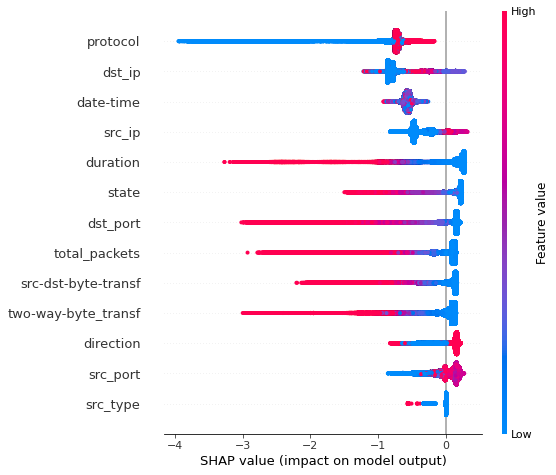

In [11]:
import shap
X_explain = variance_threshold_test_data
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_explain)
shap.summary_plot(shap_values, X_explain)

**LOCAL OUTLIER FACTOR**

In [ ]:
# Implement local outlier factor
from sklearn.neighbors import LocalOutlierFactor
clf2 = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
clf2.fit(variance_threshold_train_data)

y_pred_train = clf.predict(variance_threshold_train_data)
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1

n_errors = (y_pred_train != train_labels).sum()
print("Local Outlier Factor")
print("Number of errors: ", n_errors)

# Find accuracy of identified anomalies
training_outliers = train_labels.sum()
predicted_training_outliers = y_pred_train[y_pred_train == 1]

accurate_train_preds = accurate_outlier_preds(y_pred_train,train_labels)
train_outlier_count = np.sum(train_labels)
print("Accuracy for trainig outliers: ", accurate_train_preds/train_outlier_count)

# Find accuracy of identified anomalies
print("Classification report:\n", classification_report(list(train_labels), list(y_pred_train), target_names=['Normal', 'Anomaly']))

accurate_outlier_count = 0
for i in range(len(y_pred_train)):

    if y_pred_train[i] == 1:
        if train_labels[i] == 1:
            accurate_outlier_count +=1




In [ ]:
# # Predict on validation data
# val_data = feature_standardiser(val_data,le)

# # Remove features dropped in training data
# val_data = val_data[train_data.columns]
# val_data.head()

y_pred_val = clf2.predict(variance_threshold_val_data)

y_pred_val[y_pred_val == 1] = 0
y_pred_val[y_pred_val == -1] = 1

n_errors = (y_pred_val != val_labels).sum()
print("Local Outlier Factor")
print("Number of errors: ", n_errors)
accurate_val_preds = accurate_outlier_preds(y_pred_val,val_labels)
val_outlier_count = np.sum(val_labels)
print("Accuracy for val outliers: ", accurate_val_preds/val_outlier_count)

target_names = ['Normal', 'Anomaly']

# Compare predictions with actual labels
print(classification_report(list(val_labels), list(y_pred_val), target_names=target_names))


In [ ]:
# # Predict on test data
# test_data = feature_standardiser(test_data,le)

# # Remove features dropped in training data
# test_data = test_data[train_data.columns]
# test_data.head()

y_pred_test = clf2.predict(variance_threshold_test_data)

y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

n_errors = (y_pred_test != test_labels).sum()
print("Local Outlier Factor")
print("Number of errors: ", n_errors)
accurate_test_preds = accurate_outlier_preds(y_pred_test,test_labels)
test_outlier_count = np.sum(test_labels)
print("Accuracy for outliers: ", accurate_test_preds/test_outlier_count)

target_names = ['Normal', 'Anomaly']

# Compare predictions with actual labels
print(classification_report(list(test_labels), list(y_pred_test), target_names=target_names))

In [ ]:
# Implement and visualise PCA on training data
from turtle import color
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_data)
pca_train_data = pca.transform(train_data)

# Plot PCA
plt.figure(figsize=(10,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green', 'blue', 'yellow', 'black', 'pink', 'purple']
lw = 2
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(pca_train_data[train_labels == i, 0], pca_train_data[train_labels == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of training data')
plt.show()
plt.scatter(pca_train_data[:,0], pca_train_data[:,1], c=train_labels, cmap='coolwarm', label='Train data')
plt.title("PCA on training data")
plt.legend()
plt.show()

**Feature Visualisation with pyod**

In [ ]:
# Implement and visualise PCA on training data
from turtle import color
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(unscaled_train_data)
pca_train_data = pca.transform(train_data)
pca_val_data = pca.transform(unscaled_val_data)

# Plot PCA
plt.figure(figsize=(10,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green', 'blue', 'yellow', 'black', 'pink', 'purple']
lw = 2
for color, i, target_name in zip(colors, [0, 1], train_data.columns.to_list()):
    plt.scatter(pca_train_data[train_labels == i, 0], pca_train_data[train_labels == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of training data')
plt.show()
plt.scatter(pca_train_data[:,0], pca_train_data[:,1], c=train_labels, cmap='coolwarm', label='Train data')
plt.title("PCA on training data")
plt.legend()
plt.show()




In [ ]:
from pyod.utils.example import visualize
visualize(clf, pca_train_data, train_labels, pca_val_data, val_labels, y_pred_train,y_pred_val, show_figure=True, save_figure=False)